Authors:

Anastasiia Karpova (Group 4);
William Liaw (Group 5)

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
from sklearn import svm
from sklearn.datasets import make_blobs, make_circles
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import (GridSearchCV, cross_validate,
                                     train_test_split)
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.utils import shuffle

warnings.filterwarnings("ignore")

%matplotlib inline
plt.style.use("ggplot")

# TP: Support Vector Machine (SVM)

## Preliminary questions

**1)** Show that the primal problem solved by the SVM can be rewritten as follows :

$$
\argmin_{\mathbf{w} \in \mathcal{H}, w_0 \in \mathbb{R}}\left( \frac{1}{2}||\mathbf{w}||^2 + C \sum_{i=1}^n [ 1 - y_i (\langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0)]_+\right)
$$

<div class='alert alert-block alert-warning'>
Answer:
</div>

In the case of nonlinearly separable data, the primal problem of the linear SVM is typically formulated as follows:

$$
\argmin_{\mathbf{w} \in \mathcal{H}, w_0 \in \mathbb{R}}\left(\frac{1}{2}||\mathbf{w}||^2 + C \sum_{i=1}^n \xi_i\right)
$$

subject to the constraints:

$$
\begin{align*}
y_i (\langle \mathbf{w}, \Phi(\mathbf{x}_i) \rangle + w_0) &\geq 1 - \xi_i \quad \text{for} \quad i = 1, \dots, n \\
\xi_i &\geq 0 \quad \text{for} \quad i = 1, \dots, n
\end{align*}
$$

We observe that the constraints are fulfilled when $[1 - y_i (\langle \mathbf{w}, \Phi(\mathbf{x}_i) \rangle + w_0)]_+ \leq \xi_i$. This is due to the definition of the positive part function as $(z)_+ = \max(0, z)$, ensuring $\xi_i\geq0$. Rearranging the expression yields $y_i (\langle \mathbf{w}, \Phi(\mathbf{x}_i) \rangle + w_0) \geq 1 - \xi_i$.

Now, we rewrite the primal problem using this constraint:

$$
\argmin_{\mathbf{w} \in \mathcal{H}, w_0 \in \mathbb{R}}\left( \frac{1}{2}||\mathbf{w}||^2 + C \sum_{i=1}^n \xi_i\right)
$$

subject to the constraint:

$$
[1 - y_i (\langle \mathbf{w}, \Phi(\mathbf{x}_i) \rangle + w_0)]_+ \leq \xi_i \quad \text{for} \quad i = 1, \dots, n \\
$$

Consequently, we can rewrite $\xi_i$ to obtain:

$$
\argmin_{\mathbf{w} \in \mathcal{H}, w_0 \in \mathbb{R}} \left( \frac{1}{2}||\mathbf{w}||^2 + C \sum_{i=1}^n [ 1 - y_i (\langle \mathbf{w}, \Phi(\mathbf{x}_i) \rangle + w_0)]_+ \right)
$$

**2)** Explain the sentence : "an SVM minimizes the classification error using a convex upper bound". The function $x \rightarrow [1 - x]_+ = \text{max}(0, 1-x)$ is called *Hinge* (*charnière* en français). Explain the difference between the pivotal loss and the loss of binary classification.

<div class='alert alert-block alert-warning'>
Answer:
</div>

The sentence enlightens that SVMs are geared towards minimizing classification errors, as indicated by the hinge loss, while employing a convex loss function that offers an upper limit on the actual classification error.

Regarding the hinge loss $L(y, h(\mathbf{x})) = [1 - yh(\mathbf{x})]_+ = [1 - y_i (\langle \mathbf{w}, \Phi(\mathbf{x}_i) \rangle + w_0)]_+$, it is an affine function of $\mathbf{w}$, and thus, inherently convex. This hinge loss function tightly bounds the 0-1 loss, which represents the loss incurred through misclassification. Since the 0-1 loss is non-convex and discontinuous, its direct optimization poses challenges. Through the hinge loss function, SVMs optimize a convex objective, rendering the optimization problem manageable.

In binary classification tasks, we aim to separate data points into two classes. The pivotal aspect of SVMs is that they not only aim to classify data accurately, but also try to maximize the margin between the decision boundary and the nearest data points of each class. This margin maximization helps SVMs generalize well to unseen data and enhances their ability to resist overfitting.

1. Pivotal (hinge) loss: The pivotal loss refers to the penalization of predictions that are close to the decision boundary but on the correct side, encouraging the model to produce confident predictions with a large margin.

2. Loss of binary classification: The loss of binary classification generally refers to the loss incurred when a classifier misclassifies an example of two possible classes. The hinge loss is an example of loss of binary classification.

## Example of using the SVC class from scikit-learn

In [2]:
#  Data Generation
def rand_gauss(n=100, mu=[1, 1], sigmas=[0.1, 0.1]):
    """Sample n points from a Gaussian variable with center mu,
    and std deviation sigma
    """
    d = len(mu)
    res = np.random.randn(n, d)
    return np.array(res * sigmas + mu)


def rand_bi_gauss(
    n1=100, n2=100, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.1, 0.1], sigmas2=[0.1, 0.1]
):
    """Sample n1 and n2 points from two Gaussian variables centered in mu1,
    mu2, with respective std deviations sigma1 and sigma2
    """
    ex1 = rand_gauss(n1, mu1, sigmas1)
    ex2 = rand_gauss(n2, mu2, sigmas2)
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    X = np.vstack([ex1, ex2])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]

Training score : 0.8
Testing score : 0.85


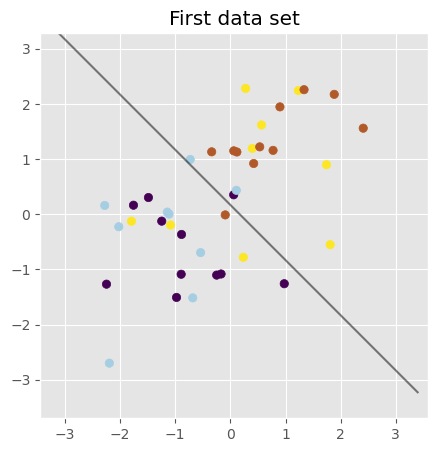

In [3]:
# This is an example of using SVC for data generated with the above function
n1 = 20
n2 = 20
mu1 = [1.0, 1.0]
mu2 = [-1.0, -1.0]
sigma1 = [0.9, 0.9]
sigma2 = [0.9, 0.9]
X1, y1 = rand_bi_gauss(n1, n2, mu1, mu2, sigma1, sigma2)

X_train = X1[::2]
Y_train = y1[::2].astype(int)
X_test = X1[1::2]
Y_test = y1[1::2].astype(int)

# fit the model with linear kernel
clf = SVC(kernel="linear")
clf.fit(X_train, Y_train)

# predict labels for the test data base
y_pred = clf.predict(X_test)

# check your score
score_train = clf.score(X_train, Y_train)
score_test = clf.score(X_test, Y_test)
print("Training score : %s" % score_train)
print("Testing score : %s" % score_test)

# display the points
plt.figure(1, figsize=(5, 5))
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    clf,
    X1,
    plot_method="contour",
    colors="k",
    levels=[0],
    alpha=0.5,
    ax=ax,
)
ax.scatter(X_train[:, 0], X_train[:, 1], c=Y_train)
ax.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, cmap=plt.cm.Paired)
plt.title("First data set")
plt.axis("equal")
plt.show()

## Linear SVM

**3)** Draw a i.i.d. sample from a mixture of two Gaussian distributions : each class is a Gaussian with specific parameters. This time, use the function ```make_blobs``` available in ```sklearn.datasets``` library. Reserve 75% of the data for training and 25% for the test data.

<div class='alert alert-block alert-info'>
            Code:</div>

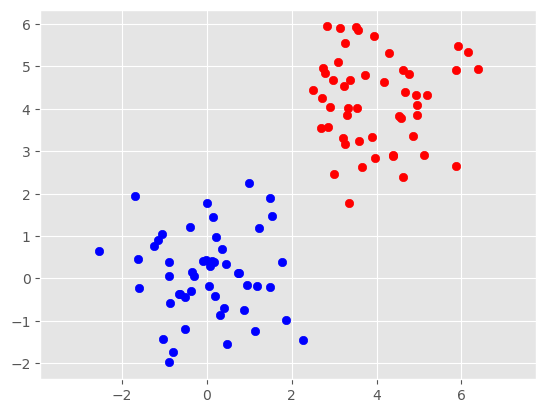

In [4]:
# Create two centers for the two distributions
centers = [(0, 0), (4, 4)]

# Use make_blobs to generate the two dimensions points from the two centers
X, y = make_blobs(
    n_samples=100, centers=centers, n_features=2, cluster_std=[1, 1], random_state=0
)

# Plot the points
pos = np.where(y == 1)[0]
neg = np.where(y == 0)[0]
plt.scatter(X[pos, 0], X[pos, 1], c="r")
plt.scatter(X[neg, 0], X[neg, 1], c="b")
plt.axis("equal")
plt.show()

In [5]:
# Use sklearn's train_test_split to divide up data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0
)

**4)** Since the probability distributions are known, numerically estimate the Bayes risk. 

<div class='alert alert-block alert-info'>
            Code:</div>

In [6]:
from scipy.stats import multivariate_normal

# Do a Monte-Carlo estimation of the Bayes Risk (given the gaussian distributions you used to generate data)
# You need to use the imported class from scipy to generate a large number of samples which you will use
# to approximate the integral of the Bayes risk
n_mc = X.shape[0]  # Repeat this n_mc times - enough to approximate
expectation = 0
for i in range(n_mc):
    # Random binary choice: will the point be generated from the first or second gaussian ?
    rand = np.random.choice(y)
    if rand == 0:
        # First case: y = 0
        x = np.random.multivariate_normal(mean=centers[0], cov=[(1, 1), (1, 1)])
    else:
        # Second case: y = 1
        x = np.random.multivariate_normal(mean=centers[1], cov=[(1, 1), (1, 1)])

    # You have to compute the conditional posterior probability of x given the 2 gaussians
    # Use the multivariate_normal.pdf() method !
    p1 = multivariate_normal.pdf(x, mean=centers[0], cov=1)
    p2 = multivariate_normal.pdf(x, mean=centers[1], cov=1)
    # Compute the risk from these and add it to the total
    expectation += min(p1 / (p1 + p2), p2 / (p1 + p2))

expectation /= n_mc

print(f"Estimated Bayes risk: {np.around(expectation, 3)}")
print(f"Estimated Bayes accuracy: {1 - np.around(expectation, 3)}")

Estimated Bayes risk: 0.016
Estimated Bayes accuracy: 0.984


**5)** Draw the decision boundary $H$ induced by SVM as well as the hyperplanes $H_1$ and $H_{−1}$. Vary the parameter C to see its impact on the number of support vectors. We can use the code in the following example: https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html.

<div class='alert alert-block alert-info'>
            Code:</div>

Train/Test scores: 1.00000/1.00000


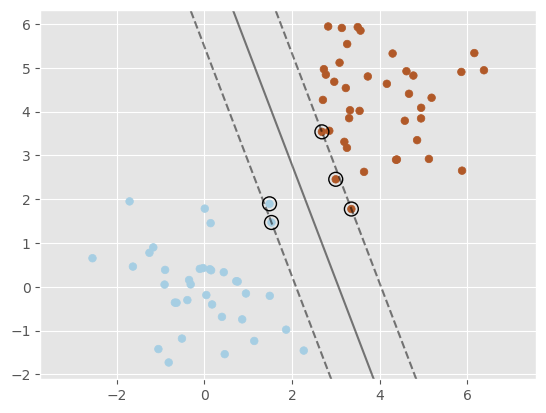

In [7]:
# Create a linear SVM and train it on the training data
clf = svm.SVC(kernel="linear", C=0.5)
clf.fit(X_train, y_train)
print(f"Train/Test scores: {clf.score(X_train, y_train):.5f}/{clf.score(X_test, y_test):.5f}")

# Plot the data
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(
    XX, YY, Z, colors="k", levels=[-1, 0, 1], alpha=0.5, linestyles=["--", "-", "--"]
)
# plot support vectors
ax.scatter(
    clf.support_vectors_[:, 0],
    clf.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
)

plt.axis("equal")
plt.show()

**6)** Define the Gaussian classes such that the two distributions overlap. Draw an i.i.d. sample from the joint probability distribution. Apply a 5-fold Cross-Validation (for example, using the function ```GridSearchCV```) to find the optimal parameter $C∗$ to classify this new dataset using a linear kernel.

<div class='alert alert-block alert-info'>
            Code:</div>

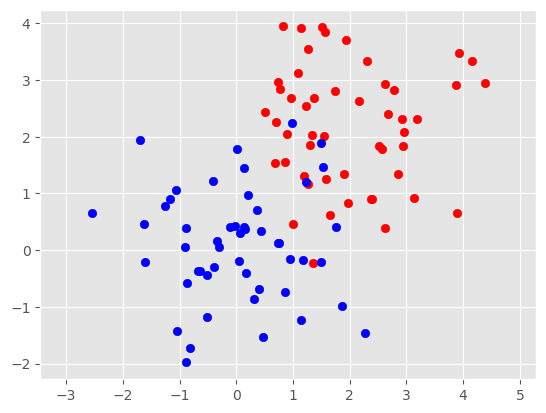

In [8]:
# Generate data and verify graphically that the two classes overlap
# Re-use the code from question 3 and 5

# Create two centers for the two distributions
centers = [(0, 0), (2, 2)]

# Use make_blobs to generate the two dimensions points from the two centers
X, y = make_blobs(
    n_samples=100, centers=centers, n_features=2, cluster_std=[1, 1], random_state=0
)

# Plot the points
pos = np.where(y == 1)[0]
neg = np.where(y == 0)[0]
plt.scatter(X[pos, 0], X[pos, 1], c="r")
plt.scatter(X[neg, 0], X[neg, 1], c="b")
plt.axis("equal")
plt.show()

In [9]:
# Use sklearn's train_test_split to divide up data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0
)

The best C parameter is: 0.03162
Train/Test scores: 0.93333/0.88000


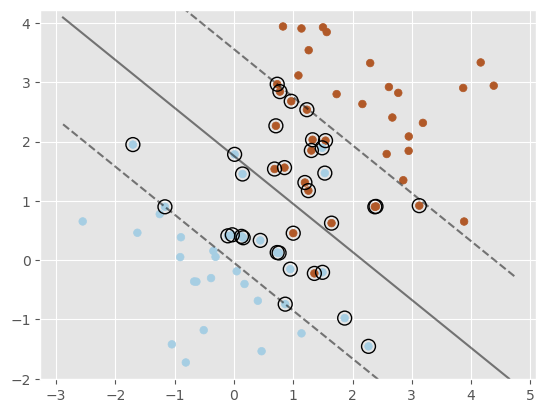

In [10]:
# Find the best working C with a 5-fold cross-validation
# Look into a bunch of values for C
parameters = {"kernel": ["linear"], "C": list(np.logspace(-3, 3, 5))}
# Use these parameters + a SVM models with GridSearchCV (look at the documentation !)

# Create a linear SVM and train it on the training data
svc = svm.SVC()
clf = GridSearchCV(estimator=svc, param_grid=parameters, n_jobs=-1, cv=5)
clf.fit(X_train, y_train)
best_C = clf.best_params_["C"]
print(f"The best C parameter is: {best_C:.5f}")

clf = clf.best_estimator_
print(f"Train/Test scores: {clf.score(X_train, y_train):.5f}/{clf.score(X_test, y_test):.5f}")

# Plot the data
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(
    XX, YY, Z, colors="k", levels=[-1, 0, 1], alpha=0.5, linestyles=["--", "-", "--"]
)
# plot support vectors
ax.scatter(
    clf.support_vectors_[:, 0],
    clf.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
)

plt.axis("equal")
plt.show()

**7)** Show how tuning SVM hyperparameters on training data, for example by taking a Gaussian kernel (the parameters are therefore $\gamma$ and $C$), can lead to overfitting.

<div class='alert alert-block alert-info'>
            Code:</div>

C: 0.00100	gamma: 0.1	Train/Test scores: 0.52000/0.44000
C: 0.03162	gamma: 0.1	Train/Test scores: 0.73333/0.64000
C: 1.00000	gamma: 0.1	Train/Test scores: 0.94667/0.88000
C: 31.62278	gamma: 0.1	Train/Test scores: 0.94667/0.88000
C: 1000.00000	gamma: 0.1	Train/Test scores: 0.96000/0.88000
C: 0.00100	gamma: 1	Train/Test scores: 0.52000/0.44000
C: 0.03162	gamma: 1	Train/Test scores: 0.52000/0.44000
C: 1.00000	gamma: 1	Train/Test scores: 0.94667/0.88000
C: 31.62278	gamma: 1	Train/Test scores: 0.97333/0.80000
C: 1000.00000	gamma: 1	Train/Test scores: 1.00000/0.72000
C: 0.00100	gamma: 10	Train/Test scores: 0.52000/0.44000
C: 0.03162	gamma: 10	Train/Test scores: 0.52000/0.44000
C: 1.00000	gamma: 10	Train/Test scores: 0.98667/0.72000
C: 31.62278	gamma: 10	Train/Test scores: 1.00000/0.68000
C: 1000.00000	gamma: 10	Train/Test scores: 1.00000/0.68000
C: 0.00100	gamma: 100	Train/Test scores: 0.52000/0.44000
C: 0.03162	gamma: 100	Train/Test scores: 0.52000/0.44000
C: 1.00000	gamma: 100	Train/Test s

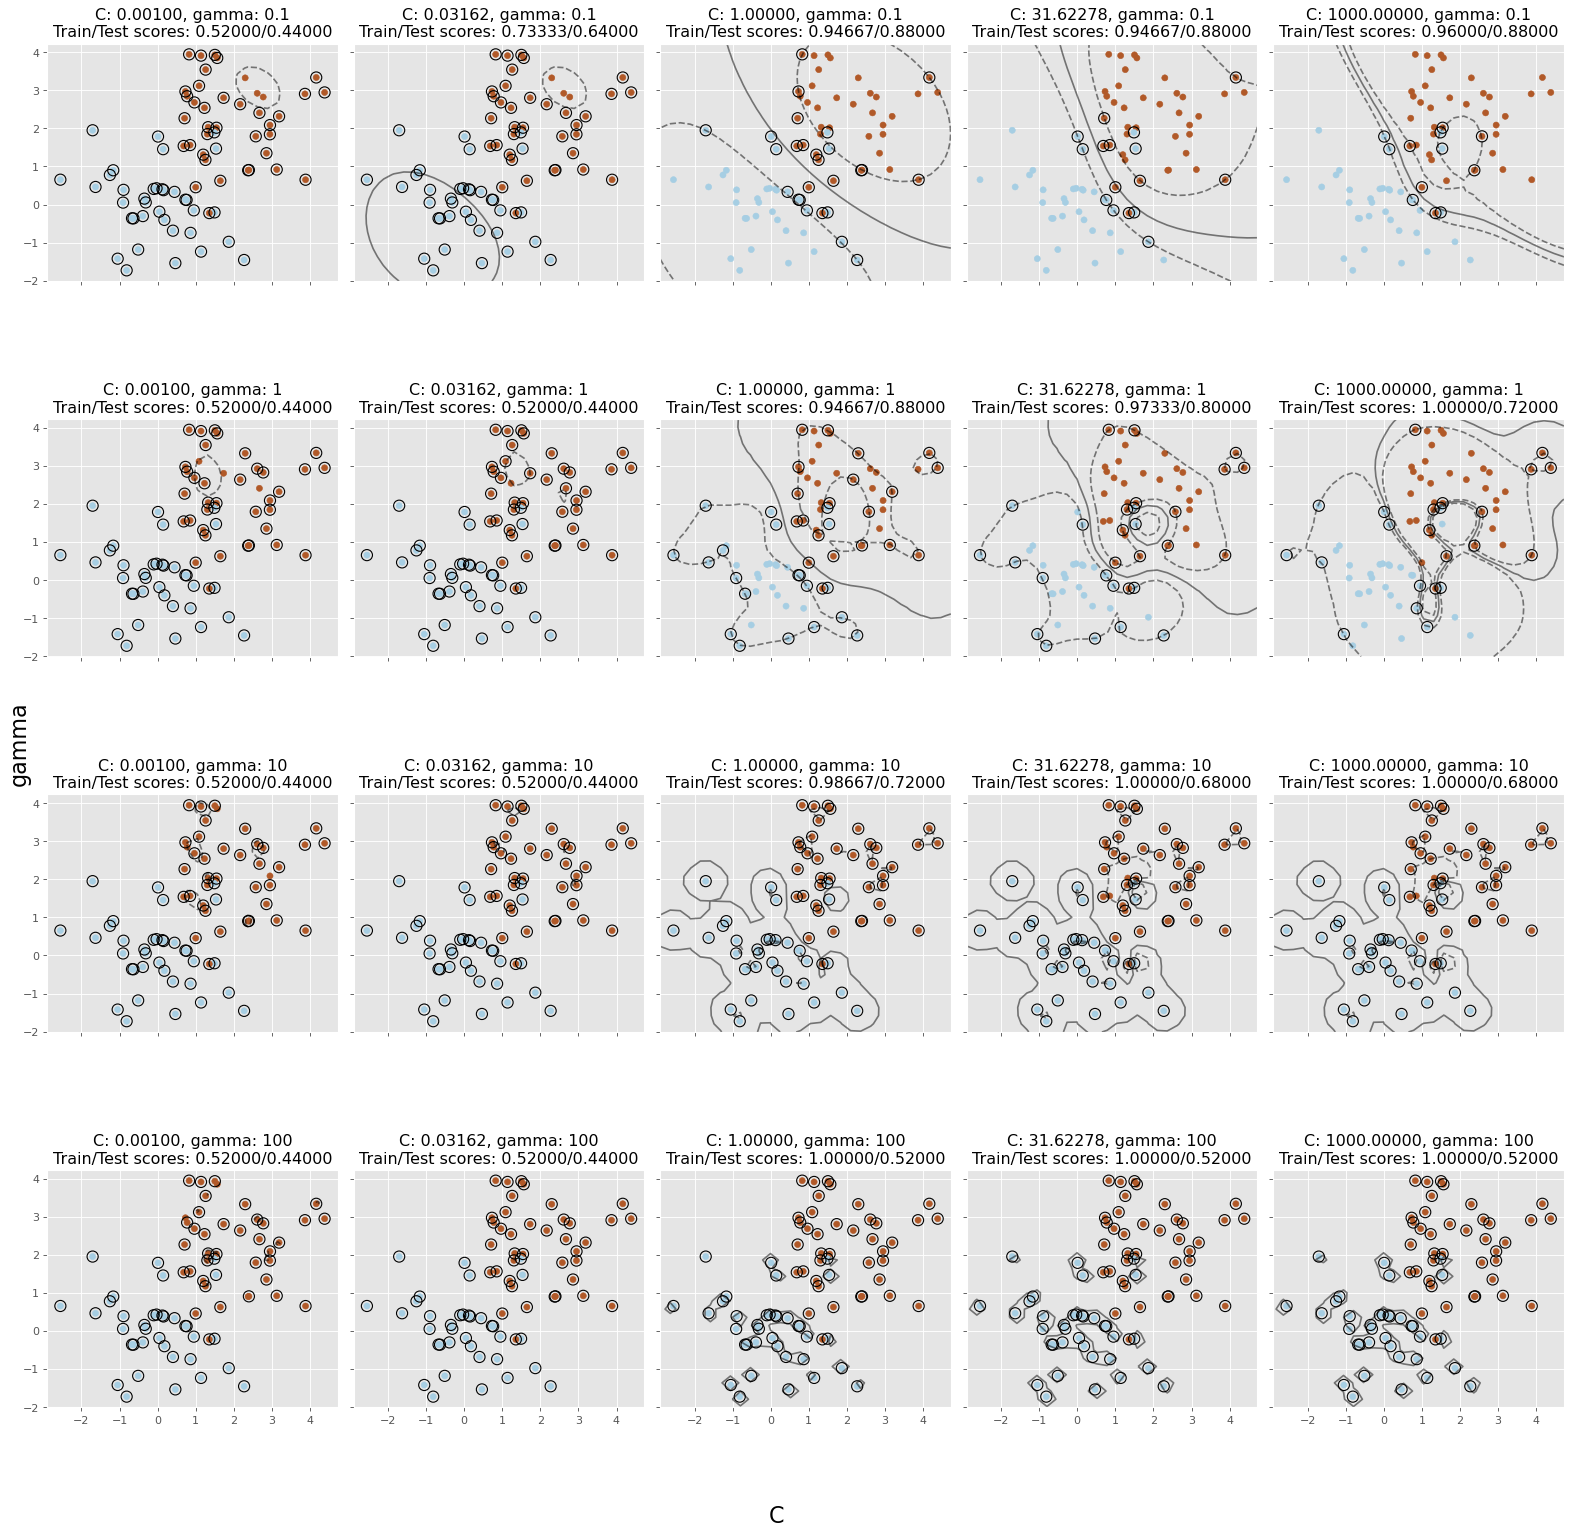

In [11]:
gammas = [0.1, 1, 10, 100]
Cs = np.logspace(-3, 3, 5)

# Create a gaussian svm and vary the parameter of the kernel, check the difference between training and testing scores

fig, axs = plt.subplots(
    nrows=len(gammas), ncols=len(Cs), sharex=True, sharey=True, figsize=(20, 20), dpi=80
)

fig.supxlabel("C", fontsize=20)
fig.supylabel("gamma", fontsize=20)

for i, gamma in enumerate(gammas):
    for j, C in enumerate(Cs):
        clf = svm.SVC(kernel="rbf", gamma=gamma, C=C)
        clf.fit(X_train, y_train)

        print(
            f"C: {C:.5f}\tgamma: {gamma}\tTrain/Test scores: {clf.score(X_train, y_train):.5f}/{clf.score(X_test, y_test):.5f}"
        )

        ax = axs[i, j]
        # Plot the data
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)

        # plot the decision function
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        # create grid to evaluate model
        xx = np.linspace(xlim[0], xlim[1], 30)
        yy = np.linspace(ylim[0], ylim[1], 30)
        YY, XX = np.meshgrid(yy, xx)
        xy = np.vstack([XX.ravel(), YY.ravel()]).T
        Z = clf.decision_function(xy).reshape(XX.shape)

        # plot decision boundary and margins
        ax.contour(
            XX,
            YY,
            Z,
            colors="k",
            levels=[-1, 0, 1],
            alpha=0.5,
            linestyles=["--", "-", "--"],
        )
        # plot support vectors
        ax.scatter(
            clf.support_vectors_[:, 0],
            clf.support_vectors_[:, 1],
            s=100,
            linewidth=1,
            facecolors="none",
            edgecolors="k",
        )

        ax.set_aspect("equal")

        ax.set_title(
            f"C: {C:.5f}, gamma: {gamma}\nTrain/Test scores: {clf.score(X_train, y_train):.5f}/{clf.score(X_test, y_test):.5f}"
        )

fig.tight_layout()
fig.show()

1. C: 
   - C is the regularization parameter in SVM. It controls the penalty for misclassification of training examples. A smaller value of C leads to a softer margin, allowing for more misclassifications, whereas a larger value of C enforces a harder margin, penalizing misclassifications heavily.
   - When C is too large, the SVM algorithm will try to minimize the training error by creating a decision boundary that perfectly separates all training data points. This can lead to overfitting, especially if the training data contains noise or outliers.
   - Conversely, when C is too small, the SVM may underfit the data by being too tolerant of misclassifications. In this case, the decision boundary might not capture the underlying structure of the data well.

2. $\gamma$:
   - Higher values of gamma tend to lead to more complex decision boundaries, which can potentially result in overfitting. This is because a high gamma allows the model to capture fine details of the training data.
   - Conversely, a very low value of gamma may lead to underfitting, as the model might fail to capture the complexity of the data.

## Non linear SVM

**8)** Define a new binary nonlinear classification problem : for instance, define one class as a Gaussian surrounded by the other chosen as a circle class, or choose the second class as a mixture of two Gaussian in such way that the separation problem is nonlinear. Generate a non-linearly separable dataset (we could for example use the function ```make_blobs``` available in ```sklearn.datasetslibrary``` ).

<div class='alert alert-block alert-info'>
            Code:</div>

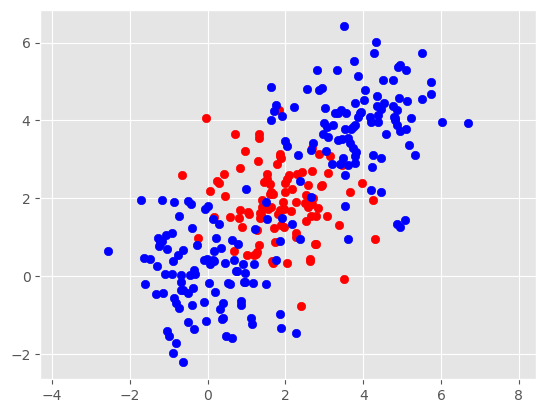

In [12]:
# Use make blobs with three centers which are aligned, for example
# Class 0 - Class 1 - Class 0

# Create two centers for the two distributions
centers = [(0, 0), (2, 2), (4, 4)]

# Use make_blobs to generate the two dimensions points from the two centers
X, y = make_blobs(
    n_samples=300, centers=centers, n_features=3, cluster_std=[1, 1, 1], random_state=0
)

y[y == 2] = 0

# Plot the points
pos = np.where(y == 1)[0]
neg = np.where(y == 0)[0]
plt.scatter(X[pos, 0], X[pos, 1], c="r")
plt.scatter(X[neg, 0], X[neg, 1], c="b")
plt.axis("equal")
plt.show()

**9)** Use an SVM with a linear kernel then a Gaussian (with well-adapted parameters, that you can obtain using, again, ```GridSearchCV```) then plot the decision boundaries of these algorithms on separate graphs.

<div class='alert alert-block alert-info'>
            Code:</div>

In [13]:
# Use the code of question 6 again

# Use sklearn's train_test_split to divide up data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0
)

The best C parameter is: 0.00100
Train/Test scores: 0.67556/0.64000


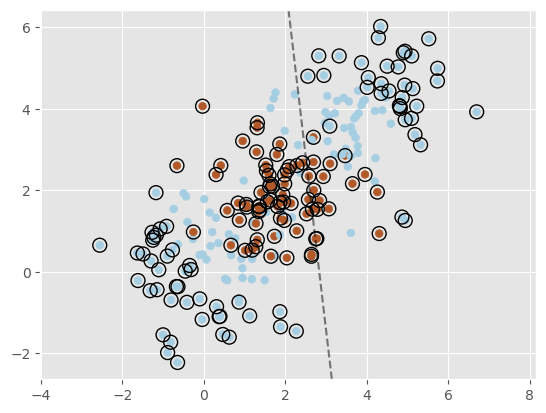

In [14]:
# Find the best working C with a 5-fold cross-validation
# Look into a bunch of values for C
parameters = {"kernel": ["linear"], "C": list(np.logspace(-3, 3, 5))}
# Use these parameters + a SVM models with GridSearchCV (look at the documentation !)

# Create a linear SVM and train it on the training data
svc = svm.SVC()
clf = GridSearchCV(estimator=svc, param_grid=parameters, n_jobs=-1, cv=5)
clf.fit(X_train, y_train)
best_C = clf.best_params_["C"]
print(f"The best C parameter is: {best_C:.5f}")

clf = clf.best_estimator_
print(f"Train/Test scores: {clf.score(X_train, y_train):.5f}/{clf.score(X_test, y_test):.5f}")

# Plot the data
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(
    XX, YY, Z, colors="k", levels=[-1, 0, 1], alpha=0.5, linestyles=["--", "-", "--"]
)
# plot support vectors
ax.scatter(
    clf.support_vectors_[:, 0],
    clf.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
)

plt.axis("equal")
plt.show()

The best parameters are:
	C: 1.00000
	gamma: 100.00000
Train/Test scores: 0.90222/0.86667


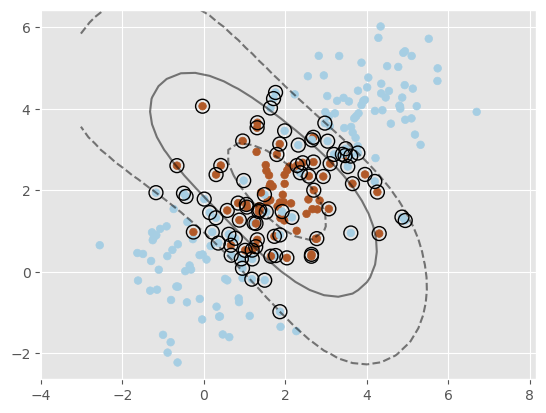

In [15]:
# Find the best working C with a 5-fold cross-validation
# Look into a bunch of values for C
parameters = {"kernel": ["rbf"], "C": list(np.logspace(-3, 3, 5)), "gamma": [0.1, 1, 10, 100]}
# Use these parameters + a SVM models with GridSearchCV (look at the documentation !)

# Create a linear SVM and train it on the training data
svc = svm.SVC()
clf = GridSearchCV(estimator=svc, param_grid=parameters, n_jobs=-1, cv=5)
clf.fit(X_train, y_train)
best_C = clf.best_params_["C"]
best_gamma = clf.best_params_["gamma"]
print(f"The best parameters are:")
print(f"\tC: {best_C:.5f}")
print(f"\tgamma: {gamma:.5f}")

clf = clf.best_estimator_
print(f"Train/Test scores: {clf.score(X_train, y_train):.5f}/{clf.score(X_test, y_test):.5f}")

# Plot the data
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(
    XX, YY, Z, colors="k", levels=[-1, 0, 1], alpha=0.5, linestyles=["--", "-", "--"]
)
# plot support vectors
ax.scatter(
    clf.support_vectors_[:, 0],
    clf.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
)

plt.axis("equal")
plt.show()

## Learning curve

**10)** Draw the learning curve of the algorithm : with fixed hyper-parameters and a fixed test set, calculate the training and test errors by using training sub-sets of training data of various sizes (drawn randomly). For each size, repeat the experiment a large number of times to average the performance. 
Plot the train and test error based on the size of the train set subset. Estimate and display the accuracy of the Bayes predictor on the same graph. Comment.

<div class='alert alert-block alert-info'>
            Code:</div>

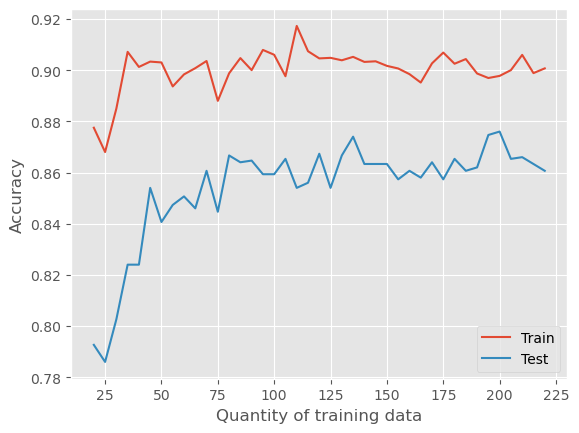

In [16]:
# Total number of training samples
n_tr = len(X_train)

# Repeat the experiment for all these training sizes
sizes = np.arange(20, n_tr, 5)

# Repeat each experiment this many times
n_m = 20

# Store scores in these lists
scores_train = []
scores_test = []

# Main loop: varying the training size
for size in sizes:
    score_train = 0
    score_test = 0
    # Second loop: repeating the experiment for each size
    for i in range(n_m):
        # Create a SVM, keeping the same parameters
        svc = svm.SVC(kernel="rbf", C=best_C, gamma=best_gamma)
        # For each experiment, draw a subset of the training data of the appropriate size
        idx = np.random.choice(range(n_tr), size=size)
        X_train_reduced = X_train[idx, :]
        y_train_reduced = y_train[idx]

        # Fit the classifier and compute the scores on training and test data
        clf.fit(X_train_reduced, y_train_reduced)
        score_train += clf.score(X_train_reduced, y_train_reduced)
        score_test += clf.score(X_test, y_test)
    # Add the average of the scores to the lists
    scores_train.append(score_train / n_m)
    scores_test.append(score_test / n_m)

# Plot the results
plt.plot(sizes, scores_train, label="Train")
plt.plot(sizes, scores_test, label="Test")
plt.xlabel("Quantity of training data")
plt.ylabel("Accuracy")

plt.legend()
plt.show()

In [17]:
# Do a Monte-Carlo estimation of the Bayes Risk (given the gaussian distributions you used to generate data)
# This is the same computation than in question 4).

n_mc = X.shape[0]  # Repeat this n_mc times - enough to approximate
expectation = 0
for i in range(n_mc):
    # Random binary choice: will the point be generated from the first or second gaussian ?
    rand = np.random.choice(y)
    if rand == 0:
        # First case: y = 0
        x = np.random.multivariate_normal(mean=centers[0], cov=[(1, 1), (1, 1)])
    else:
        # Second case: y = 1
        x = np.random.multivariate_normal(mean=centers[1], cov=[(1, 1), (1, 1)])

    # You have to compute the conditional posterior probability of x given the 2 gaussians
    # Use the multivariate_normal.pdf() method !
    p1 = multivariate_normal.pdf(x, mean=centers[0], cov=1)
    p2 = multivariate_normal.pdf(x, mean=centers[1], cov=1)
    # Compute the risk from these and add it to the total
    expectation += min(p1 / (p1 + p2), p2 / (p1 + p2))

expectation /= n_mc

print(f"Estimated Bayes risk: {np.around(expectation, 3)}")
print(f"Estimated Bayes accuracy: {1 - np.around(expectation, 3)}")

Estimated Bayes risk: 0.085
Estimated Bayes accuracy: 0.915


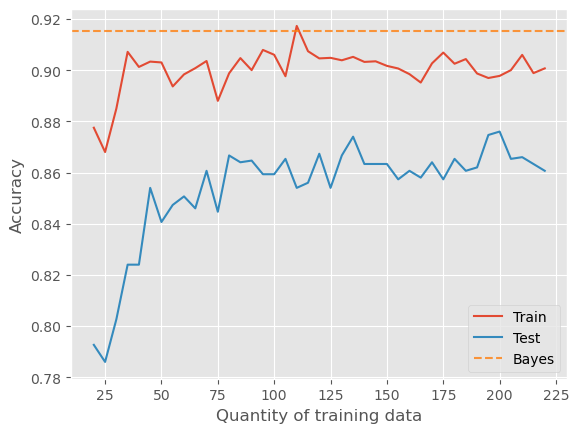

In [18]:
# Add this estimation to the plot of train/test error
# This is constant: you should add a horizontal line to your graph

# Plot the results
plt.plot(sizes, scores_train, label="Train")
plt.plot(sizes, scores_test, label="Test")
plt.axhline(1 - expectation, c="tab:orange", label="Bayes", linestyle="--", alpha=0.8)
plt.xlabel("Quantity of training data")
plt.ylabel("Accuracy")

plt.legend()
plt.show()

<div class='alert alert-block alert-warning'>
Answer:
</div>

The learning curve illustrates how the performance of a machine learning algorithm changes as the size of the training dataset subset varies. Initially, with a small subset, both training and testing accuracy are low due to the model's inadequate exposure to the data: the data does not correctly represent the original distributions. As more training data is provided, the model's performance improves, leading to a increase in testing accuracy. However, there comes a point where adding more data doesn't significantly increase the training accuracy further. Meanwhile, the testing accuracy initially increases as the model learns from more data but may start to decrease after reaching an optimal point. This decrease is attributed to overfitting, where the model begins to memorize noise in the training data rather than learning underlying patterns, resulting in poor generalization to unseen data.

The accuracy of the Bayes predictor, representing the best achievable performance given the data distribution, serves as a benchmark for assessing the algorithm's effectiveness. Ideally, the algorithm's performance approaches the Bayes predictor's accuracy, indicating effective learning and capturing of underlying data patterns. Identifying the point where the testing accuracy stabilizes or begins to decrease helps determine the optimal training dataset size for achieving the best generalization performance. Beyond this point, adding more data might not yield substantial improvements in the model's performance, emphasizing the importance of balancing model complexity and dataset size for efficient learning and generalization.

## Error versus complexity

**11)** Add noise to the dataset by randomly modifying the labels of some training data. Then, draw the complexity curves of the algorithm : with set train and test set, draw the train and test error as a function of the complexity (i.e. as a function of the value of the hyper-parameter controlling the complexity, or the number of support vector). Comment.

<div class='alert alert-block alert-info'>
            Code:</div>

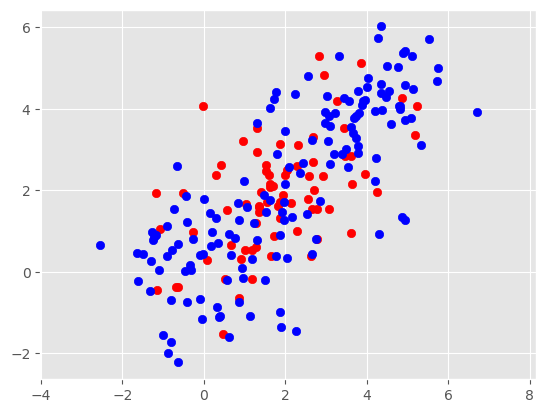

In [19]:
# Modify the class of some data points randomly
n_noise = 50
n_tr = len(y_train)
idx = np.random.choice(range(n_tr), n_noise)
y_train[idx] = 1 - y_train[idx]

pos = np.where(y_train == 1)[0]
neg = np.where(y_train == 0)[0]

# Visualise the data
plt.scatter(X_train[pos, 0], X_train[pos, 1], c="r")
plt.scatter(X_train[neg, 0], X_train[neg, 1], c="b")
plt.axis("equal")
plt.show()

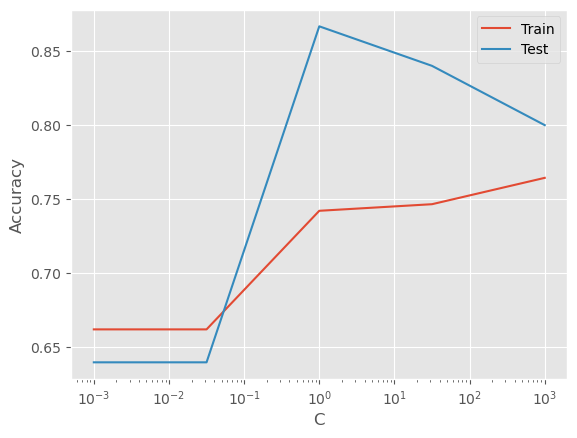

In [20]:
# Vary the appropriate parameter and plot the training/testing results

Cs = list(np.logspace(-3, 3, 5))

scores_train = []
scores_test = []

for C in Cs:
    clf = SVC(kernel="rbf", gamma=best_gamma, C=C)
    clf.fit(X_train, y_train)
    scores_train.append(clf.score(X_train, y_train))
    scores_test.append(clf.score(X_test, y_test))

plt.plot(Cs, scores_train, label="Train")
plt.plot(Cs, scores_test, label="Test")
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.xscale("log")
plt.legend()
plt.show()

<div class='alert alert-block alert-warning'>
Answer:
</div>

C is a critical parameter in SVM models, regulating the balance between model complexity and training classification error. As C increases, the model becomes less tolerant of misclassifications, potentially leading to a more flexible decision boundary. Consequently, the training accuracy improves with increasing values of C. However, further increases in C may result in overfitting, where the model excessively tailors itself to the training data, diminishing its ability to generalize to unseen data, as seen by the drop in testing accuracy, as the model begins to capture noise or irrelevant patterns present in the training data.

## Bonus : Application to face classification

Code for downloading and organizing the data:

In [21]:
###############################################################################
#               Face Recognition Task
###############################################################################
"""
The dataset used in this example is a preprocessed excerpt
of the "Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

  _LFW: http://vis-www.cs.umass.edu/lfw/

"""

from time import time

import pylab as pl
from sklearn.datasets import fetch_lfw_people


####################################################################
# Download the data (if not already on disk); load it as numpy arrays
lfw_people = fetch_lfw_people(
    min_faces_per_person=70,
    resize=0.4,
    color=True,
    funneled=False,
    slice_=None,
    download_if_missing=True,
)
# data_home='.'

# introspect the images arrays to find the shapes (for plotting)
images = lfw_people.images
n_samples, h, w, n_colors = images.shape

# the label to predict is the id of the person
target_names = lfw_people.target_names.tolist()

####################################################################
# Pick a pair to classify such as
names = ["Tony Blair", "Colin Powell"]
# names = ['Donald Rumsfeld', 'Colin Powell']

idx0 = lfw_people.target == target_names.index(names[0])
idx1 = lfw_people.target == target_names.index(names[1])
images = np.r_[images[idx0], images[idx1]]
n_samples = images.shape[0]
y = np.r_[np.zeros(np.sum(idx0)), np.ones(np.sum(idx1))].astype(int)

####################################################################
# Extract features

# features using only illuminations
X = (np.mean(images, axis=3)).reshape(n_samples, -1)

# # or compute features using colors (3 times more features)
# X = images.copy().reshape(n_samples, -1)

# Scale features
X -= np.mean(X, axis=0)
X /= np.std(X, axis=0)

####################################################################
# Split data into a half training and half test set
# X_train, X_test, y_train, y_test, images_train, images_test = \
#    train_test_split(X, y, images, test_size=0.5, random_state=0)
# X_train, X_test, y_train, y_test = \
#    train_test_split(X, y, test_size=0.5, random_state=0)

indices = np.random.permutation(X.shape[0])
train_idx, test_idx = indices[: int(X.shape[0] / 2)], indices[int(X.shape[0] / 2) :]
X_train, X_test = X[train_idx, :], X[test_idx, :]
y_train, y_test = y[train_idx], y[test_idx]
images_train, images_test = images[train_idx, :, :, :], images[test_idx, :, :, :]

**12)** By modifying the following code, show the influence of the regularization parameter. For example, the prediction error can be displayed as a function of $C$ on a logarithmic scale between $1e5$ and $1e-5$.

<div class='alert alert-block alert-info'>
            Code:</div>

Fitting the classifier to the training set: done in 0.145s
Fitting the classifier to the training set: done in 0.124s
Fitting the classifier to the training set: done in 0.121s
Fitting the classifier to the training set: done in 0.114s
Fitting the classifier to the training set: done in 0.115s
Fitting the classifier to the training set: done in 0.115s
Fitting the classifier to the training set: done in 0.115s
Fitting the classifier to the training set: done in 0.112s
Fitting the classifier to the training set: done in 0.115s
Fitting the classifier to the training set: done in 0.117s
The best C parameter is: 0.00167


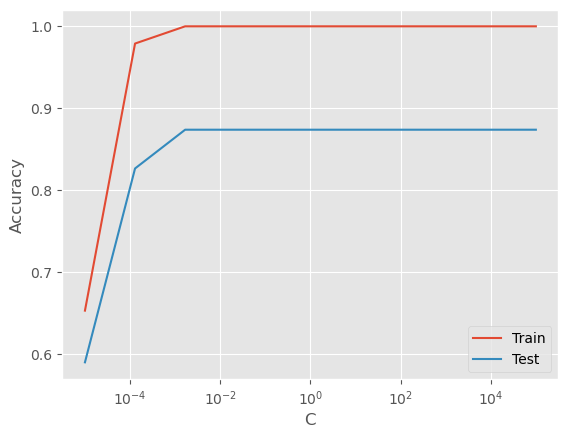

In [22]:
####################################################################
# Quantitative evaluation of the model quality on the test set

# Add the regularization parameter and test for a range of values
# Plot the performances
Cs = list(np.logspace(-5, 5, 10))

scores_train = []
scores_test = []

for C in Cs:
    clf = SVC(kernel="linear", C=C)
    t0 = time()
    clf.fit(X_train, y_train)
    print("Fitting the classifier to the training set: done in %0.3fs" % (time() - t0))
    scores_train.append(clf.score(X_train, y_train))
    scores_test.append(clf.score(X_test, y_test))

print(f"The best C parameter is: {Cs[np.argmax(scores_test)]:.5f}")
clf_best = SVC(kernel="linear", C=Cs[np.argmax(scores_test)])
clf_best.fit(X_train, y_train)

plt.plot(Cs, scores_train, label="Train")
plt.plot(Cs, scores_test, label="Test")
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.xscale("log")
plt.legend()
plt.show()


In [23]:
print("Predicting the people names on the testing set")
t0 = time()

# Predict labels for the X_test images with the best regularization parameter you obtained
y_pred = clf_best.predict(X_test)

print(f"done in {time() - t0:.3f}")
print(f"Chance level : {max(np.mean(y), 1.0 - np.mean(y))}")
print(f"Accuracy test : {clf_best.score(X_test, y_test):.5f}")

Predicting the people names on the testing set
done in 0.072
Chance level : 0.6210526315789474
Accuracy test : 0.87368


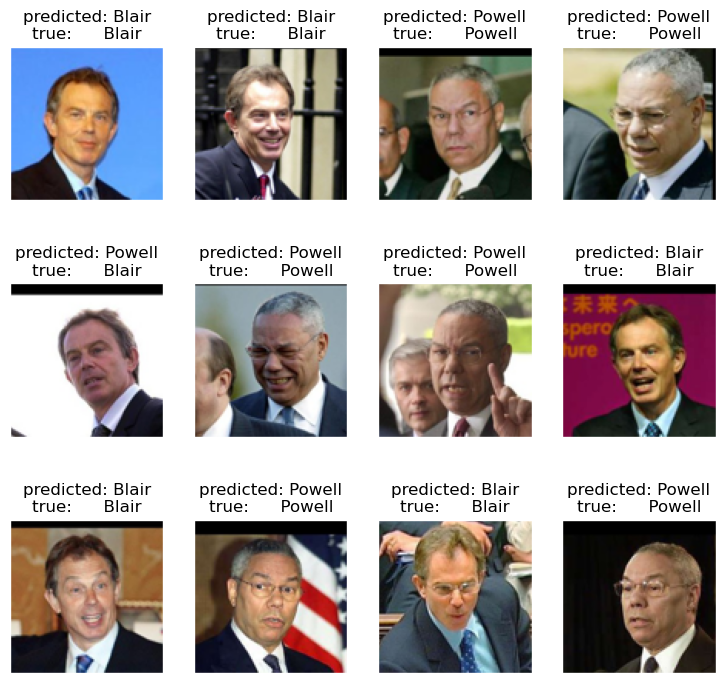

In [24]:
####################################################################
# Qualitative evaluation of the predictions using matplotlib


def plot_gallery(images, titles, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i])
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())


def title(y_pred, y_test, names):
    pred_name = names[int(y_pred)].rsplit(" ", 1)[-1]
    true_name = names[int(y_test)].rsplit(" ", 1)[-1]
    return "predicted: %s\ntrue:      %s" % (pred_name, true_name)


# This will just show some examples with their associated prediction - nothing to change
prediction_titles = [title(y_pred[i], y_test[i], names) for i in range(y_pred.shape[0])]

plot_gallery(images_test, prediction_titles)
pl.show()

**13)** By adding nuisance variables, thus increasing the number of variables to the number of learning
points fixed, show that performance drops.

<div class='alert alert-block alert-info'>
            Code:</div>

In [25]:
# Add a number of nuisance variable to the existing data points, by generating randomly their values

n_noise = 100

X_train_noisy = np.hstack(
    (X_train, np.random.rand(X_train.shape[0], n_noise))
)[:, np.random.permutation(X_train.shape[1])]
X_test_noisy = np.hstack(
    (X_test, np.random.rand(X_test.shape[0], n_noise))
)[:, np.random.permutation(X_test.shape[1])]

Fitting the classifier to the training set: done in 0.155s
Fitting the classifier to the training set: done in 0.124s
Fitting the classifier to the training set: done in 0.188s
Fitting the classifier to the training set: done in 0.128s
Fitting the classifier to the training set: done in 0.120s
Fitting the classifier to the training set: done in 0.120s
Fitting the classifier to the training set: done in 0.120s
Fitting the classifier to the training set: done in 0.120s
Fitting the classifier to the training set: done in 0.119s
Fitting the classifier to the training set: done in 0.119s
The best C parameter is: 0.00001


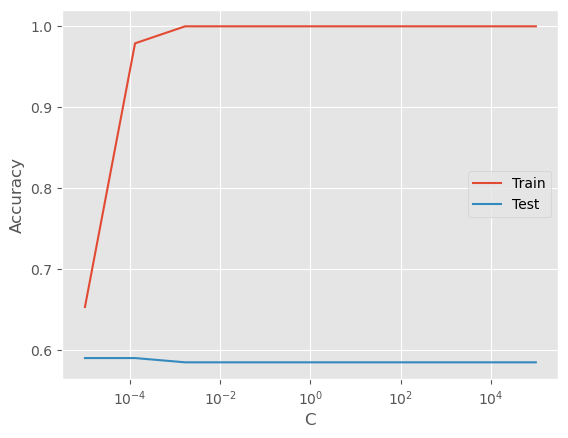

In [26]:
####################################################################
# Quantitative evaluation of the model quality on the test set

# Add the regularization parameter and test for a range of values
# Plot the performances
Cs = list(np.logspace(-5, 5, 10))

scores_train = []
scores_test = []

for C in Cs:
    clf = SVC(kernel="linear", C=C)
    t0 = time()
    clf.fit(X_train_noisy, y_train)
    print("Fitting the classifier to the training set: done in %0.3fs" % (time() - t0))
    scores_train.append(clf.score(X_train_noisy, y_train))
    scores_test.append(clf.score(X_test_noisy, y_test))

print(f"The best C parameter is: {Cs[np.argmax(scores_test)]:.5f}")
clf_best_noisy = SVC(kernel="linear", C=Cs[np.argmax(scores_test)])
clf_best_noisy.fit(X_train_noisy, y_train)

plt.plot(Cs, scores_train, label="Train")
plt.plot(Cs, scores_test, label="Test")
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.xscale("log")
plt.legend()
plt.show()

In [27]:
print("Predicting the people names on the testing set")
t0 = time()

# Predict labels for the X_test images with the best regularization parameter you obtained
y_pred = clf_best_noisy.predict(X_test_noisy)

print(f"done in {time() - t0:.3f}")
print(f"Chance level : {max(np.mean(y), 1.0 - np.mean(y))}")
print(f"Accuracy test : {clf_best_noisy.score(X_test_noisy, y_test):.5f}")
print(f"Performance drop : {clf_best.score(X_test, y_test) - clf_best_noisy.score(X_test_noisy, y_test):.5f}")

Predicting the people names on the testing set
done in 0.120
Chance level : 0.6210526315789474
Accuracy test : 0.58947
Performance drop : 0.28421


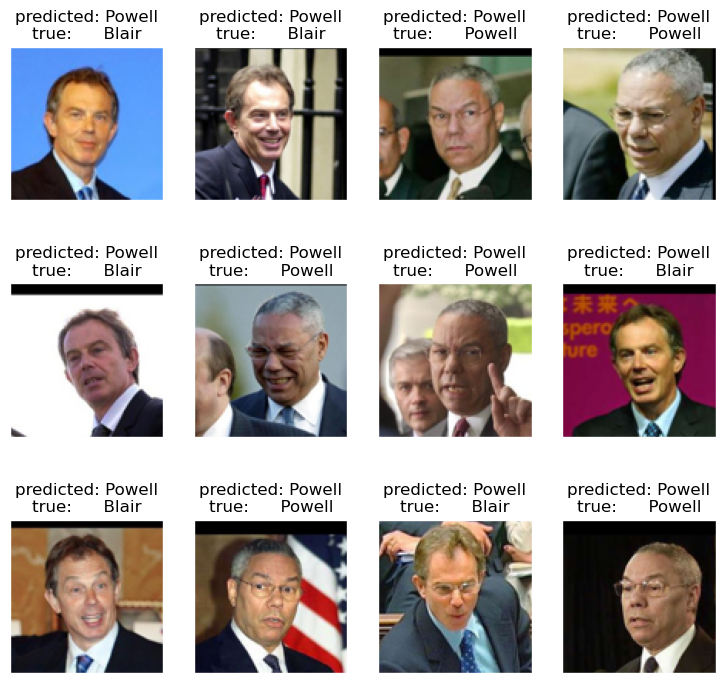

In [28]:
prediction_titles = [title(y_pred[i], y_test[i], names) for i in range(y_pred.shape[0])]

plot_gallery(images_test, prediction_titles)
pl.show()

**14)** What is the effect of choosing a non-linear RBF kernel on prediction ? You will be able to improve the prediction with a reduction of dimension based on the object ```sklearn.decomposition.RandomizedPCA```.

<div class='alert alert-block alert-info'>
            Code:</div>

In [29]:
parameters = {"kernel": ["rbf"], "C": np.logspace(-10, 4, 10), "gamma": [0.1, 1, 10, 100, 1000]}

svc = svm.SVC()
clf = GridSearchCV(estimator=svc, param_grid=parameters, n_jobs=-1, cv=5)
clf.fit(X_train_noisy, y_train)

best_C = clf.best_params_["C"]
best_gamma = clf.best_params_["gamma"]
print(f"The best parameters are:")
print(f"\tC: {best_C}")
print(f"\tgamma: {gamma:.5f}")

clf = clf.best_estimator_
print(f"Train/Test scores: {clf.score(X_train_noisy, y_train):.5f}/{clf.score(X_test_noisy, y_test):.5f}")

The best parameters are:
	C: 1e-10
	gamma: 100.00000
Train/Test scores: 0.65263/0.58947


The performance drops substantially by choosing a non-linear RBF kernel. The best parameter chosen by the grid search is always the lowest possible value of C. We, thus, choose to proceed with the linear kernel for further considerations.

In [30]:
# Apply the SVM with the chosen kernel after dimension reduction by

from sklearn.decomposition import PCA

pca = PCA(random_state=0)
X_train_noisy_PCA = pca.fit_transform(X_train_noisy)
X_test_noisy_PCA = pca.transform(X_test_noisy)

# Threshold defined as 99% of the variability
var_explained_cum = np.cumsum(pca.explained_variance_ratio_)
PCAComp = len(var_explained_cum[var_explained_cum < 0.99]) + 1
print(f"PCA uses {PCAComp} features from the original dimensionality of {X.shape[1]}")

X_train_noisy_PCA = X_train_noisy_PCA[:, :PCAComp]
X_test_noisy_PCA = X_test_noisy_PCA[:, :PCAComp]

PCA uses 161 features from the original dimensionality of 10000


In [31]:
parameters = {"kernel": ["linear"], "C": np.logspace(-5, 5, 50)}

svc = svm.SVC()
clf_pca = GridSearchCV(estimator=svc, param_grid=parameters, n_jobs=-1, cv=5)
clf_pca.fit(X_train_noisy_PCA, y_train)

best_C = clf_pca.best_params_["C"]
print(f"The best parameters are:")
print(f"\tC: {best_C}")

clf_pca = clf_pca.best_estimator_
print(
    f"Train/Test scores: {clf_pca.score(X_train_noisy_PCA, y_train):.5f}/{clf_pca.score(X_test_noisy_PCA, y_test):.5f}"
)
print(
    f"Performance improvement: {clf_pca.score(X_test_noisy_PCA, y_test) - clf_best_noisy.score(X_test_noisy, y_test):.5f}"
)

The best parameters are:
	C: 0.00016768329368110083
Train/Test scores: 0.98947/0.58947
Performance improvement: 0.00000


The training and prediction time was considerably improved, as the complexity (dimensionality) of the dataset was significantly reduced. An improvement in performance was not observed.